In [ ]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import pandas as pd
from bs4 import BeautifulSoup as bs
from datetime import datetime
from hdfs import InsecureClient
import folium
import os

In [10]:
#Chrome 옵션설정
options = Options()
options.binary_location = ".\\chrome-win64\\chrome.exe" # chrome 경로설정
options.add_argument("--no-sanbox")# sandbox설정
options.add_argument("--disable-dev-shm-usage") # 공유메모리 설정
options.add_argument("--window-size=1920,1080") # 화면크기설정, 반응형 웹 대비
# options.add_argument("--disable-gpu") # GPU 비활성화

download_path = "C:\\Users\\Admin\\Downloads"

#chromedriver 설정
service = Service("chromedriver.exe")
driver = webdriver.Chrome(service=service, options=options)
driver.get("https://www.opinet.co.kr/user/main/mainView.do")
print(driver.title)

time.sleep(2)
hover_element = driver.find_element(By.CSS_SELECTOR, "#header > div > ul > li:nth-child(1) > a")
menu_option = driver.find_element(By.CSS_SELECTOR, "#header > div > ul > li:nth-child(1) > ul > li:nth-child(1) > a")
actions = ActionChains(driver)
actions.move_to_element(hover_element).perform()

time.sleep(1)
menu_option.click()
time.sleep(5)

html = driver.page_source
soup = bs(html,"html.parser")

soup = bs(html,"html.parser")
contents = soup.select("#SIGUNGU_NM0 > option")
place = []

for a in contents:
    result = a["value"]
    place.append(result)
place.pop(0)

for n in range(2,17):
    time.sleep(4)
    driver.find_element(By.CSS_SELECTOR, f"#SIGUNGU_NM0 > option:nth-child({n})").click()
    time.sleep(0.5)
    driver.find_element(By.CSS_SELECTOR, "#templ_list0 > div:nth-child(7) > div > a > span").click() 
    list_of_files = os.listdir(download_path)
    latest_file = max([os.path.join(download_path, f) for f in list_of_files], key=os.path.getctime)
    new_file = f"주유소_{place}.csv"
    new_name = os.path.joun(download_path, new_file)
    if os.path.exists(latest_file):
        os.rename(latest_file, new_name)
    else:
        print("파일을 찾을 수 없습니다")
    local_path = f"C:\\Users\\Admin\\Downloads\\{new_file}"
    hdfs_path = f"/user/hadoop/{new_file}"
    hdfs.upload(hdfs_path, local_path, overwrite = True)
    print(f"업로드{n-1}이 완료되었습니다")
    

싼 주유소 찾기 오피넷


''

Text(0.2, 0.4, '한글')

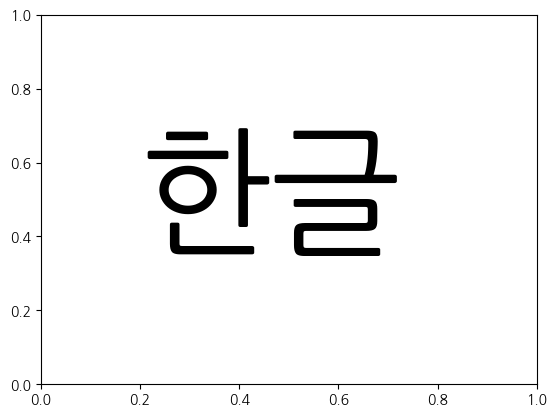

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from matplotlib import rc
from datetime import datetime
from hdfs import InsecureClient

# 리눅스용 한글 폰트실행
plt.rc('font', family="NanumBarunGothic")
plt.text(0.2,0.4,'한글',size=100)

# 윈도우용 한글 폰트 실행 
path = "C:\\Windows\\Fonts\\NanumGothic.ttf"
font_name = fm.FontProperties(fname=path).get_name()
rc('font',family=font_name)
plt.text(0.2,0.4,'한글',size=100)

In [ ]:
hdfs = InsecureClient("http://namenode:9870", user = "hadoop")
datas = []
for path in place:
    with hdfs.read(f"/user/hadoop/{path}.scv", encoding="utf-8") as reader:
        datas.append(pd.read_csv(reader))

data = pd.concat(datas, ignore_index=True)
data


In [ ]:
data.columns = data.iloc[1]
data = data.drop(index=1).reset_index(drop=True)
data

In [ ]:
data = data.drop(index=0).reset_index(drop=True)
data

In [ ]:
data['휘발유'] = data['휘발유'].str.replace('-', '0').str.replace('휘발유', '0').astype(float)

In [ ]:
data = data[["상호","주소","휘발유"]]
data["휘발유"] = data["휘발유"].fillna(0).astype(int)


In [ ]:
data = data[data["휘발유"]>0]
data

In [ ]:
data_max = data.nlargest(5,"휘발유")
data_min = data.nsmallest(5,"휘발유")
print(data_max)
print(data_min)

In [ ]:
data = pd.concat([data_max,data_min], ignore_index=True)
data.to_csv("주유소과제.csv", index=False)

In [ ]:
file_path = "data/ref/주유소과제.csv"
data1 = pd.read_csv('./ref/주유소과제.csv', encoding = "utf_8")
data1

In [ ]:
coordinates = data1[['위도','경도']].to_numpy()
place = data1["상호"].to_numpy()

# 중심좌표 설정(기본 위치)
center_lat , center_lon = 35.17574571, 129.0817409

# 지도 생성
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for i, (lat, lon) in enumerate(coordinates):   
    folium.CircleMarker(
        location = [lat, lon], 
        radious = 10,
        color = "blue",
        fill = True,
        weight = 1,
        fill_color = "skyblue",
        fill_opacity = 0.5,
        tooltip = place[i]
    ).add_to(m) #지도 생성후 원을 그리고 지도에 붙임
    folium.Marker(
        location = [lat + 0.001, lon],
        icon = folium.DivIcon(f'<div style="font=size: 9px; color: black; background-color: white; width:50px; while-space: nowrap; overflow: hidden; text-overflow: ellipsis; opactiy:0.7; border-radius:5px">{place[i]}</div>')
    ).add_to(m)

m